### Imports:

In [32]:
from lxml import etree
from lxml.etree import XMLSyntaxError
import pandas as pd
import networkx as nx
from natsort import index_natsorted, order_by_index
from itertools import combinations

#helper functions:
from ipynb.fs.defs.helper_functions import relevant_keywords, coauthor_relevant_keywords, relevant_phrases

### Reading in graph

In [27]:
author_graph = nx.read_gpickle("author_graph.gpickle")

### Visualizing subgraph of author_graph
Param: name of author, depth (depth = 2 means coauthors of coauthors)

In [121]:
def draw_subgraph(author_name, coauthor_depth = 1):
    author_list = list(nx.dfs_preorder_nodes(author_graph, source=author_name, depth_limit=coauthor_depth))
    subgraph = author_graph.subgraph(author_list)
    pos = nx.circular_layout(author_graph)
    nx.draw(subgraph, pos = pos, with_labels = True)

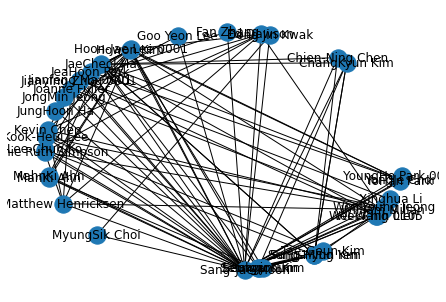

In [122]:
draw_subgraph("Sang-Jae Moon", 1)

### 10 Authors with most coauthors

In [116]:
print(str(sorted(author_graph.degree, key=lambda x: x[1], reverse=True)[0:10]) + "\n")

[('Wei Wang', 771), ('Yang Liu', 727), ('Wei Zhang', 653), ('Wei Li', 650), ('Lei Zhang', 626), ('Lei Wang', 621), ('Xin Li', 617), ('Jing Li', 610), ('Wei Liu', 608), ('Xin Wang', 595)]



### Are there certain groups of researchers that are “cliquish” and only work with each other?

This algorithm investigates if a significant amount of an author's work is done with an exclusive group of other researchers

Param: author to be inspected, author graph

Return: list of coauthors that are part of author's cliquish group of research partners

In [35]:
def find_cliquish(author_name, author_graph=author_graph):
    co_authors = {} #dictionary mapping coauthor name to number of publications with them
    coauthor_list = list(nx.dfs_preorder_nodes(author_graph, source=author_name, depth_limit=1))
    for coauthor in coauthor_list: #iterate through coauthors
        if coauthor == author_name:
            continue
        author_publications = author_graph.nodes[author_name]["Publications"] #list of publications by author
        co_author_publications = author_graph.nodes[coauthor]["Publications"] #list of publications by coauthor
        num_in_common = len(set(author_publications) & set(co_author_publications)) #number of publications together between authors (common elements in two lists)
        co_authors.update({coauthor : num_in_common}) #add coauthor to coauthor dictionary
    sorted_co_authors = sorted(co_authors.items(), key=lambda item: item[1], reverse=True) #sort list of coauthors by number of publications together
    partition = 0 #partition coauthor list in half: those who work with this author a lot, and those who don't
    num_co_authors = len(sorted_co_authors)
    if (num_co_authors > 0 and sorted_co_authors[0][1] >= 20 and
        sorted_co_authors[0][1] > len(author_publications) / 3): #if first coauthor takes up over 1/3 of publications
        while sorted_co_authors[partition][1] > len(author_publications) / 3:
            # print("publications together: " + str(sorted_co_authors[partition][1]))
            # print("total/4: " + str(len(author_publications) / 4))
            partition += 1
        # print(partition)
        len_smaller_half = num_co_authors - partition
        avg_pubs_smaller = 0
        for val in sorted_co_authors[partition:num_co_authors]:
            avg_pubs_smaller += val[1]
        avg_pubs_smaller /= len_smaller_half
        if avg_pubs_smaller < sorted_co_authors[partition-1][1]/4: #if avg publications for less popular coauthors is less than num publications with last most popular coauthor
            return sorted_co_authors[0:partition], len(author_publications)
    return None

### Test for cliquish algorithm

In [ ]:
authors = list(nx.dfs_preorder_nodes(author_graph, source="Wei Li", depth_limit=2))
for author in list(authors):
    if (find_cliquish(author) != None):
        print(author + ": " + str(find_cliquish(author)[0]) + " out of " + str(find_cliquish(author)[1]) + " total publications")
print("done")

### Shared Topics of Publications Between two Authors

Param: two author names

Return: list of topics that two authors both cover in publications

In [44]:
def similar_topics(author1, author2, author_graph=author_graph):
    rel_phrases1 = relevant_phrases(author1, author_graph)
    rel_phrases2 = relevant_phrases(author2, author_graph)
    topics_in_common = [val for val in rel_phrases1 if val in rel_phrases2]
    return topics_in_common